In [14]:
import pandas as pd
import numpy as np
import os

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter('ignore')

In [5]:
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 100)

#### read csv files from kaggle 

In [6]:
df_gemini_price_d = pd.read_csv('datasets/kaggle/BTCUSD_day.csv')
df_gemini_price_1h = pd.read_csv('datasets/kaggle/BTCUSD_1hr.csv')

#### convert columns to datetime

In [7]:
df_gemini_price_d['Date'] = pd.to_datetime(df_gemini_price_d['Date'])
df_gemini_price_1h['Date'] = pd.to_datetime(df_gemini_price_1h['Date'])

#### verify the range of datetime in dataframes

In [8]:
print('------------', 'df_gemini_price_d', '------------')
print(df_gemini_price_d['Date'].max())
print(df_gemini_price_d['Date'].min())
print('------------', 'df_gemini_price_1h', '------------')
print(df_gemini_price_1h['Date'].max())
print(df_gemini_price_1h['Date'].min())

------------ df_gemini_price_d ------------
2020-04-09 00:00:00
2015-10-08 00:00:00
------------ df_gemini_price_1h ------------
2020-04-09 00:00:00
2015-10-08 13:00:00


#### verify the numbers of lines in dataframes

In [9]:
print('------------', 'df_coinmarket_price_d', '------------')
print(df_gemini_price_d.shape[0])
print('------------', 'df_coinmarket_price_1h', '------------')
print(df_gemini_price_1h.shape[0])

------------ df_coinmarket_price_d ------------
1646
------------ df_coinmarket_price_1h ------------
39468


In [22]:
class LSTMForecast(object):

    def __init__(self, df, percentage_train_size):

        self.df = df
        self.percentage_train_size = percentage_train_size
        self.path = '/home/ricardo/Documents/tcc_files/TCC/tcc_scripts_notebook/models/'
        # self.seed = np.random.seed(42)

    def perform(self):

        data_raw, min_max_scaler = self.prepare_data()
        data_train, data_test = self.split_train_test(data_raw)
        best_train_parameters = self.grid_search_lstm(min_max_scaler = min_max_scaler,
                                                    data_raw = data_raw)
        df_train, df_test = self.predict_lstm(data_raw = data_raw,
                                            best_train_parameters = best_train_parameters,
                                            min_max_scaler = min_max_scaler)

        return df_train, df_test

    def predict_lstm(self, data_raw, best_train_parameters, min_max_scaler):

        print('->predict<-')

        num_units = best_train_parameters["num_units"]
        batch_size = best_train_parameters["batch_size"]
        epochs = best_train_parameters["epochs"]

        name_file = 'lstm_{0}_{1}_{2}.h5'.format(batch_size, num_units, epochs)
        
        list_dir = os.listdir(self.path)

        if name_file in list_dir:
            print('load the model')
            print('->', name_file, '<-')
            model = load_model(self.path+name_file)

        else:

            model = self.build_model(num_units, batch_size)
            model.fit(
                X_train,
                y_train,
                batch_size = batch_size,
                epochs = epochs
            )

        train_size = self.calculate_train_size(data_raw)
        X_data, y_data = self.create_dataset(data_raw, batch_size)

        X_train, y_train = X_data[:train_size-batch_size], y_data[:train_size-batch_size]
        X_test, y_test = X_data[train_size-batch_size:], y_data[train_size-batch_size:]

        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        test_predict = model.predict(X_test)

        y_test_inverse = min_max_scaler.inverse_transform(y_test.reshape(-1, 1))
        test_predict_inverse = min_max_scaler.inverse_transform(test_predict)

        train_predict = model.predict(X_train)

        y_train_inverse = min_max_scaler.inverse_transform(y_train.reshape(-1, 1))
        train_predict_inverse = min_max_scaler.inverse_transform(train_predict)

        train_score = np.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
        print('Train Score: %.2f RMSE' % (train_score))
        test_score = np.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
        print('Test Score: %.2f RMSE' % (test_score))

        y_test_inverse = y_test_inverse.reshape(-1)
        test_predict_inverse = test_predict_inverse.reshape(-1)

        y_train_inverse = y_train_inverse.reshape(-1)
        train_predict_inverse = train_predict_inverse.reshape(-1)

        date_train = self.df[batch_size:train_size]['Date'].values
        date_test = self.df[train_size:]['Date'].values

        mae, mape, mse, rmse, rmspe, r2, pearson = self.perform_metrics(y_test_inverse, test_predict_inverse)
        print('mae', mae, 'mape', mape, 'mse', mse, 'rmse', rmse, 'rmspe', rmspe, 'r2', r2, 'pearson', pearson)

        data_train = {
          'date_train': date_train,
          'y_train': y_train_inverse,
          'y_train_predict': train_predict_inverse
        }

        data_test = {
            'date_test': date_test,
            'y_test': y_test_inverse,
            'y_test_predict': test_predict_inverse
        }

        df_train = pd.DataFrame(data_train)
        df_test = pd.DataFrame(data_test)

        return df_train, df_test

    def prepare_data(self):

        min_max_scaler = MinMaxScaler()
        data_raw = self.df['Close'].values.reshape(-1, 1)
        data_raw = data_raw.astype('float32')
        data_raw = min_max_scaler.fit_transform(data_raw)

        return data_raw, min_max_scaler

    def create_dataset(self, dataset, look_back=1):

        data_x, data_y = [], []

        for i in range(len(dataset)-look_back):

            data = dataset[i:(i+look_back), 0]
            data_x.append(data)
            data_y.append(dataset[i + look_back, 0])

        return np.array(data_x), np.array(data_y)

    def calculate_train_size(self, data_raw):

        train_size = int(len(data_raw) * self.percentage_train_size)

        return train_size

    def split_train_test(self, data_raw):

        train_size = self.calculate_train_size(data_raw)
        data_train, data_test = data_raw[:train_size], data_raw[train_size:]

        return data_train, data_test

    def perform_metrics(self, y_truth, y_forecasted): 

        mae = round(mean_absolute_error(y_truth, y_forecasted) ,4)
        mape = round(np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100, 4)
        mse = round(mean_squared_error(y_truth, y_forecasted), 4)
        rmse = round(mse**(0.5), 4)
        rmspe = round((np.sqrt(np.mean(np.square((y_truth - y_forecasted) / y_truth)))) * 100, 4)
        r2 = round(r2_score(y_truth, y_forecasted), 4)
        try:
            corr, _ = pearsonr(y_truth, y_forecasted)
            pearson = round(corr, 4)
        except:
            pearson = None

        return mae, mape, mse, rmse, rmspe, r2, pearson

    def build_model(self, num_units, batch_size):

        model = Sequential()
        model.add(LSTM(
                    units = num_units, 
                    activation = 'relu', 
                    input_shape=(batch_size, 1) ))
        model.add(Dropout(rate = 0.2))
        model.add(Dense(units = 1))
        model.compile(
            optimizer = 'adam',
            loss = 'mean_squared_error'
        )

        return model

    def grid_search_lstm(self, data_raw, min_max_scaler):

        best_train_score = np.inf
        train_size = int(len(data_raw) * 0.80)

        params = {
            "num_units": [5, 25, 50, 100],
            "batch_size": [5, 25, 50, 100],
            "num_epochs": [25, 50, 100, 200]
        }

        for batch_size in params['batch_size']:
            for units in params['num_units']:
                for epochs in params['num_epochs']:

                    name_file = 'lstm_{0}_{1}_{2}.h5'.format(batch_size, units, epochs)
                    list_dir = os.listdir(self.path)
                    print('->', name_file, '<-')

                    X_data, y_data = self.create_dataset(data_raw, batch_size)
                    X_train, y_train = X_data[:train_size-batch_size], y_data[:train_size-batch_size]
                    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

                    if name_file in list_dir:
                        model = load_model(self.path+name_file)
                        print('load the model')
                    else:
                        model = self.build_model(units, batch_size)

                        model.fit(X_train,
                                  y_train,
                                  batch_size = batch_size,
                                  epochs = epochs,
                                  verbose = 0)

                    if not name_file in list_dir:
                        model.save(self.path+name_file)

                    train_predict = model.predict(X_train)

                    y_train_inverse = min_max_scaler.inverse_transform(y_train.reshape(-1, 1))
                    train_predict_inverse = min_max_scaler.inverse_transform(train_predict)

                    train_score = np.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
                    print('Train Score: %.2f RMSE' % (train_score))
                    print('batch_size', batch_size, 'units', units, 'epochs', epochs)
                    print('---           ---')

                    if train_score < best_train_score:

                        best_train_score = train_score
                        best_train_parameters = {
                            'batch_size': batch_size,
                            'num_units': units,
                            'epochs': epochs
                        }

        print('best_train_parameters', best_train_parameters)
        print('best_train_score', best_train_score)

        return best_train_parameters

In [18]:
# df = df_gemini_price_d.copy()
df = df_gemini_price_1h.copy()

df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values(by = ['Date'])

lstm_forecast = LSTMForecast(df = df.copy(),
                             percentage_train_size = 0.80)
df_train, df_test = lstm_forecast.perform()

-> lstm_5_5_25.h5 <-
load the model
Train Score: 432.92 RMSE
batch_size 5 units 5 epochs 25
---           ---
-> lstm_5_5_50.h5 <-
load the model
Train Score: 660.17 RMSE
batch_size 5 units 5 epochs 50
---           ---
-> lstm_5_5_100.h5 <-
load the model
Train Score: 1253.31 RMSE
batch_size 5 units 5 epochs 100
---           ---
-> lstm_5_5_200.h5 <-
load the model
Train Score: 725.70 RMSE
batch_size 5 units 5 epochs 200
---           ---
-> lstm_5_25_25.h5 <-
load the model
Train Score: 156.87 RMSE
batch_size 5 units 25 epochs 25
---           ---
-> lstm_5_25_50.h5 <-
load the model
Train Score: 182.38 RMSE
batch_size 5 units 25 epochs 50
---           ---
-> lstm_5_25_100.h5 <-
load the model
Train Score: 158.04 RMSE
batch_size 5 units 25 epochs 100
---           ---
-> lstm_5_25_200.h5 <-
load the model
Train Score: 138.86 RMSE
batch_size 5 units 25 epochs 200
---           ---
-> lstm_5_50_25.h5 <-
load the model
Train Score: 109.34 RMSE
batch_size 5 units 50 epochs 25
---      

In [18]:
# LSTM manual grid 1d
# best_train_parameters {'batch_size': 5, 'num_units': 50, 'epochs': 200}
# Train Score: 288.76 RMSE
# Test Score: 403.48 RMSE
# mae 263.4817 mape 3.0512 mse 162799.98 rmse 403.4848 rmspe 5.3534 r2 0.929 pearson 0.9651

In [15]:
# LSTM manual grid 1h
# best_train_parameters {'batch_size': 100, 'num_units': 100, 'epochs': 200}
# Train Score: 70.58 RMSE
# Test Score: 84.73 RMSE
# mae 46.9182 mape 0.5445 mse 7178.51 rmse 84.7261 rmspe 1.0366 r2 0.9969 pearson 0.9985

In [19]:
# df_train.tail()
df_test.head()

# df_train.to_csv('train_lstm_1d.csv', sep = "\t", index = False)
# df_test.to_csv('test_lstm_1d.csv', sep = "\t", index = False)
# pd.read_csv('train_lstm_1d.csv', sep = "\t")
# pd.read_csv('test_lstm_1d.csv', sep = "\t")

# df_train.to_csv('train_lstm_1h.csv', sep = "\t", index = False)
# df_test.to_csv('test_lstm_1h.csv', sep = "\t", index = False)
# pd.read_csv('train_lstm_1h.csv', sep = "\t")
# pd.read_csv('test_lstm_1h.csv', sep = "\t")

,date_test,y_test,y_test_predict
0,2019-05-16 03:00:00,8247.339844,8341.382812
1,2019-05-16 04:00:00,7983.680176,8279.277344
2,2019-05-16 05:00:00,7994.150391,8048.267090
3,2019-05-16 06:00:00,8126.339844,8007.125977
4,2019-05-16 07:00:00,8010.720215,8111.075195


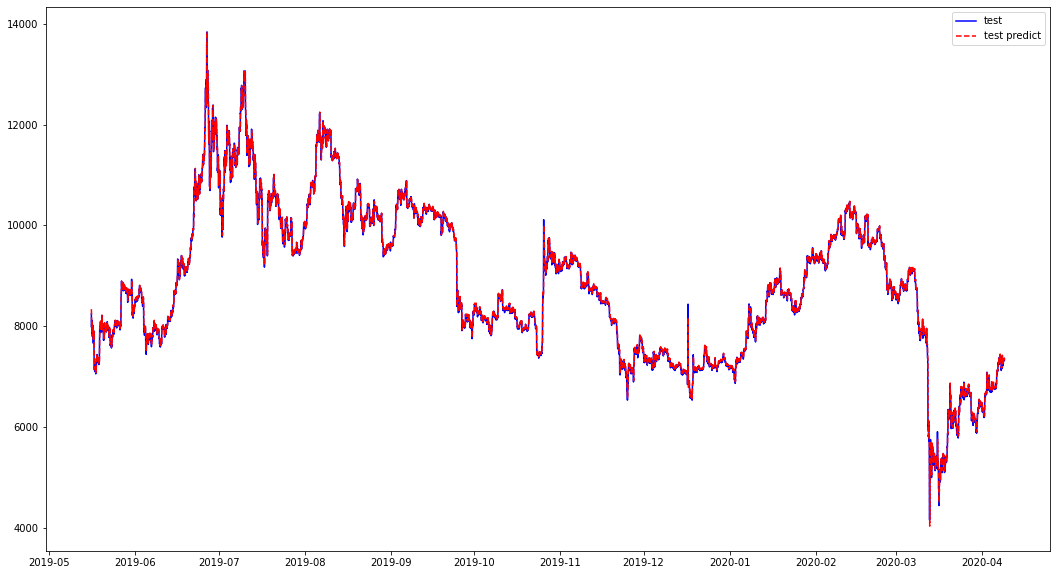

In [21]:
fig, ax = plt.subplots(figsize=(18, 10))

# ax.plot(df_train['date_train'], df_train['y_train'], label = 'train', color="blue")
# ax.plot(df_train['date_train'], df_train['y_train_predict'], '--', label = 'train predict', color="red")

ax.plot(df_test['date_test'], df_test['y_test'], label = 'test', color="blue")
ax.plot(df_test['date_test'], df_test['y_test_predict'], '--', label = 'test predict', color="red")

ax.legend()
plt.show()